In [1]:
import gc
import os
import random
import time
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt

# model
import torch
import torchvision
import torch.nn as nn
import timm
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.transforms.functional as TF

# data loader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset

# training
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, ExponentialLR

# metric
from sklearn.metrics import fbeta_score, roc_auc_score

import wandb

# config

In [2]:
BASE_DIR = "/working/"
EXP_NAME = "exp014"
OUTPUT_DIR = os.path.join(BASE_DIR, "output", EXP_NAME)

# metric

In [3]:
def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta_auc(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    dice_list = [] 
    # for th in np.array(range(10, 50+1, 5)) / 100:
    for th in np.array(range(10, 100+1, 5)) / 100:
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice_list.append(dice)
        # print(f'\t th: {th}, fbeta: {dice}')
        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    auc = roc_auc_score(mask, mask_pred)
    # Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th, auc, dice_list


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th, auc, dice_list = calc_fbeta_auc(mask_gt, mask_pred)

    return best_dice, best_th, auc, dice_list

# model

# main

---
# OOF SCORE CHECK

/working/output/exp014/imgs/fold0_average_slice555_valid_pred_img.png
(7606, 5249)
(7606, 5249)


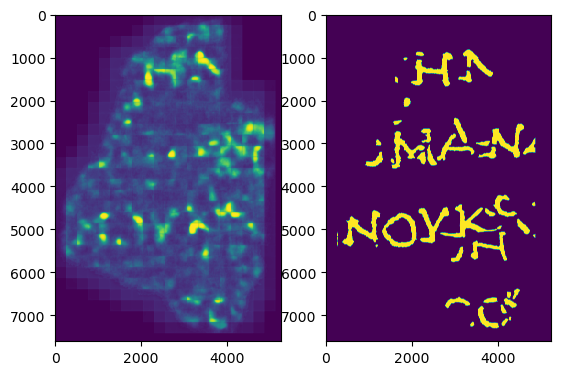

/working/output/exp014/imgs/fold1_average_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


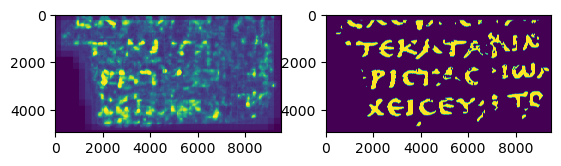

/working/output/exp014/imgs/fold2_average_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


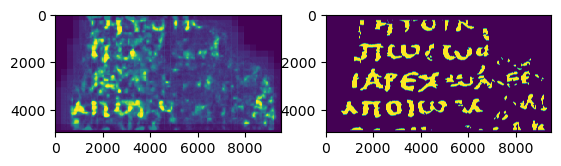

/working/output/exp014/imgs/fold3_average_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


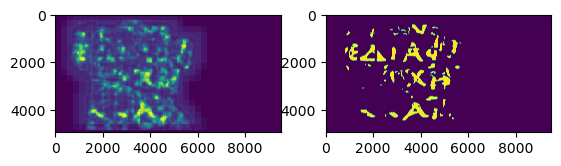

/working/output/exp014/imgs/fold4_average_slice555_valid_pred_img.png
(8181, 6330)
(8181, 6330)


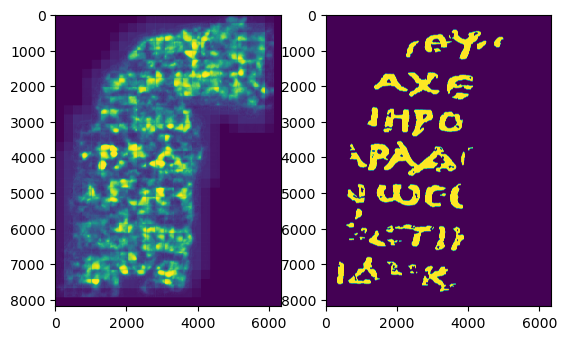

CPU times: user 17.4 s, sys: 7.63 s, total: 25 s
Wall time: 23.2 s


In [4]:
%%time
pred_flatten_list = []
mask_flatten_list = []
for fold in [0,1,2,3,4]:
    pred_path = os.path.join(OUTPUT_DIR, "imgs", f"fold{fold}_average_slice555_valid_pred_img.png")
    mask_path = os.path.join(OUTPUT_DIR, "imgs", f"fold{fold}_average_slice555_valid_targets_img.png")
    print(pred_path)
    pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    print(pred_img.shape)
    print(mask_img.shape)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(pred_img)
    plt.subplot(1, 2, 2)
    plt.imshow(mask_img)
    plt.show()
    pred_flatten_list.extend(pred_img.flatten())
    mask_flatten_list.extend(mask_img.flatten())

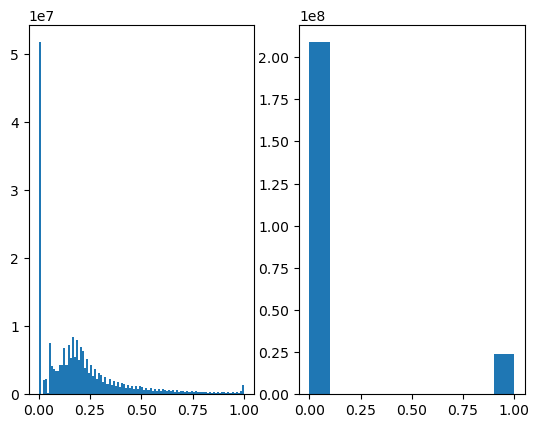

th=0.10, dice=0.1854
th=0.15, dice=0.2177
th=0.20, dice=0.2684
th=0.25, dice=0.3237
th=0.30, dice=0.3685
th=0.35, dice=0.4080
th=0.40, dice=0.4401
th=0.45, dice=0.4703
th=0.50, dice=0.4987
th=0.55, dice=0.5186
th=0.60, dice=0.5293
th=0.65, dice=0.5341
th=0.70, dice=0.5313
th=0.75, dice=0.5170
th=0.80, dice=0.4940
th=0.85, dice=0.4576
th=0.90, dice=0.4044
th=0.95, dice=0.3257
th=1.00, dice=0.1492


In [5]:
mask_flatten_list = np.array(mask_flatten_list)/255.
mask = np.array(mask_flatten_list).astype(int)
pred = np.array(pred_flatten_list)/255.

plt.figure()
plt.subplot(1, 2, 1)
plt.hist(pred, bins=100)
plt.subplot(1, 2, 2)
plt.hist(mask)
plt.show()

for th in np.array(range(10, 100+1, 5)) / 100:
    dice = fbeta_numpy(mask, (pred >= th).astype(int), beta=0.5)
    print(f"th={th:.2f}, dice={dice:.4f}")

fold[0] slice ave score:0.5541(th=0.897338), auc=0.600000  
fold[1] slice ave score:0.5659(th=0.858590), auc=0.650000  
fold[2] slice ave score:0.5316(th=0.839597), auc=0.600000  
fold[3] slice ave score:0.5648(th=0.926478), auc=0.600000  
fold[4] slice ave score:0.5130(th=0.892056), auc=0.750000  

In [6]:
threshols =[0.60000, 0.650000, 0.60000, 0.60000, 0.75000]
print(np.mean(threshols))

0.64


---
# Gaussian Blur TTA

/working/output/exp014/imgs/fold0_average_slice555_valid_pred_img.png
(7606, 5249)
(7606, 5249)


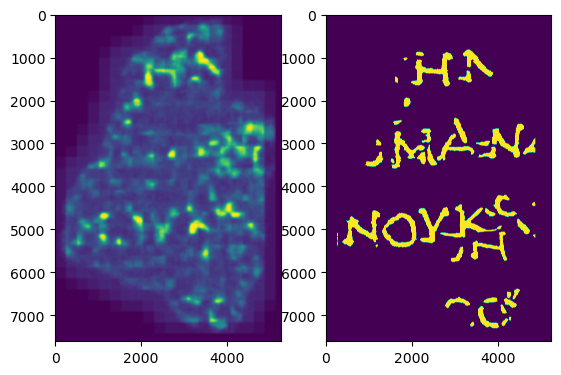

/working/output/exp014/imgs/fold1_average_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


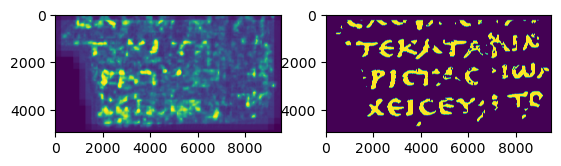

/working/output/exp014/imgs/fold2_average_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


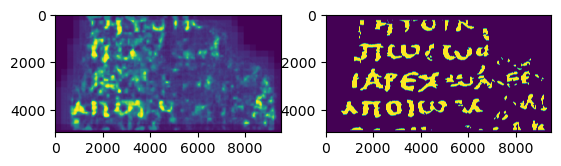

/working/output/exp014/imgs/fold3_average_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


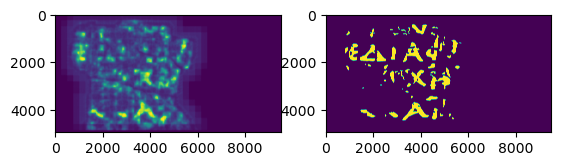

/working/output/exp014/imgs/fold4_average_slice555_valid_pred_img.png
(8181, 6330)
(8181, 6330)


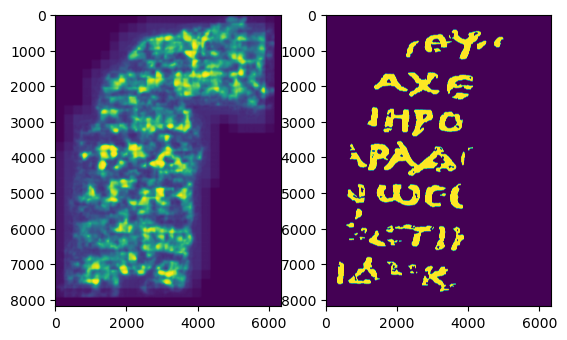

CPU times: user 20.6 s, sys: 6.3 s, total: 26.9 s
Wall time: 24.4 s


In [7]:
%%time
pred_flatten_list = []
mask_flatten_list = []
for fold in [0,1,2,3,4]:
    pred_path = os.path.join(OUTPUT_DIR, "imgs", f"fold{fold}_average_slice555_valid_pred_img.png")
    mask_path = os.path.join(OUTPUT_DIR, "imgs", f"fold{fold}_average_slice555_valid_targets_img.png")
    print(pred_path)
    pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    pred_img = cv2.GaussianBlur(pred_img, (65, 65), 32)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    print(pred_img.shape)
    print(mask_img.shape)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(pred_img)
    plt.subplot(1, 2, 2)
    plt.imshow(mask_img)
    plt.show()
    pred_flatten_list.extend(pred_img.flatten())
    mask_flatten_list.extend(mask_img.flatten())

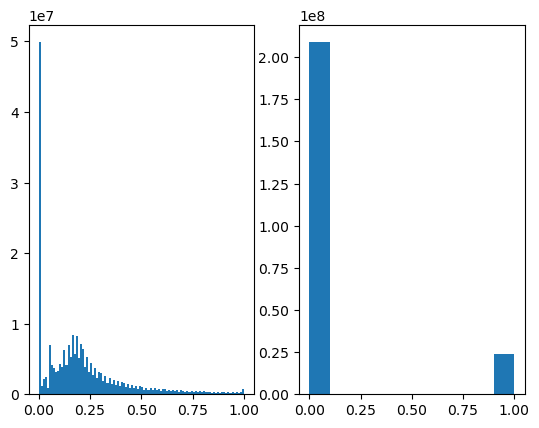

th=0.10, dice=0.1847
th=0.15, dice=0.2152
th=0.20, dice=0.2665
th=0.25, dice=0.3215
th=0.30, dice=0.3669
th=0.35, dice=0.4077
th=0.40, dice=0.4417
th=0.45, dice=0.4744
th=0.50, dice=0.5031
th=0.55, dice=0.5235
th=0.60, dice=0.5355
th=0.65, dice=0.5389
th=0.70, dice=0.5300
th=0.75, dice=0.5086
th=0.80, dice=0.4767
th=0.85, dice=0.4265
th=0.90, dice=0.3522
th=0.95, dice=0.2464
th=1.00, dice=0.0671


In [8]:
mask_flatten_list = np.array(mask_flatten_list)/255.
mask = np.array(mask_flatten_list).astype(int)
pred = np.array(pred_flatten_list)/255.

plt.figure()
plt.subplot(1, 2, 1)
plt.hist(pred, bins=100)
plt.subplot(1, 2, 2)
plt.hist(mask)
plt.show()

for th in np.array(range(10, 100+1, 5)) / 100:
    dice = fbeta_numpy(mask, (pred >= th).astype(int), beta=0.5)
    print(f"th={th:.2f}, dice={dice:.4f}")